# Análisis de Sentimientos Binario por Reglas (Versión 2)
**Sin ML, sin deep learning, sin modelos preentrenados**.  
Usa **tokenización**, **reglas lingüísticas**, **WordNet/SentiWordNet** y **estadística simple**.  
Optimizado para datasets grandes (200k+) con **caché**, **reglas de contraste ("but")**, **emojis/emoticonos**, y **descargas NLTK robustas**.

**Checklist de aceptación**
- [ ] Se instalan/importan librerías necesarias automáticamente si faltan.
- [ ] Descargas NLTK sólo si los recursos no están presentes.
- [ ] Preprocesado conserva señales de sentimiento y maneja URLs, menciones, emojis y emoticonos.
- [ ] Scoring por reglas + SentiWordNet con **memorización (cache)**.
- [ ] Negación con ventana, **reset por puntuación**, e intensificadores/atenuadores.
- [ ] Regla de **contraste con 'but/however/though'** (pre: ×0.5, post: ×1.5).
- [ ] Calibración de umbral por **balanced accuracy** en una muestra.
- [ ] Evaluación con métricas manuales + gráficos opcionales.
- [ ] Exportación a CSV.

## 1. Instalación y configuración inicial

In [1]:
# Instalación de dependencias mínimas si no están presentes
import subprocess, sys, importlib

def ensure(package, import_name=None):
    name = import_name or package
    try:
        importlib.import_module(name)
        return True
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        importlib.invalidate_caches()
        importlib.import_module(name)
        return True

for pkg, imp in [
    ("nltk", "nltk"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("tqdm", "tqdm"),
    ("emoji", "emoji"),
    ("matplotlib", "matplotlib"),
]:
    ensure(pkg, imp)

print("✓ Dependencias listas")

✓ Dependencias listas


## 2. Descarga de recursos NLTK (robusta y condicional)

In [2]:
import ssl
import nltk

# Forzar contexto SSL laxo si hace falta
try:
    _create_unverified_https_context = ssl._create_unverified_context  # type: ignore
    ssl._create_default_https_context = _create_unverified_https_context
except Exception:
    pass

to_check = {
    "punkt": "tokenizers/punkt",
    "wordnet": "corpora/wordnet",
    "omw-1.4": "corpora/omw-1.4",
    "averaged_perceptron_tagger": "taggers/averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng": "taggers/averaged_perceptron_tagger_eng",
    "sentiwordnet": "corpora/sentiwordnet",
}

def ensure_nltk(resource, path_fragment):
    try:
        nltk.data.find(path_fragment)
        return True
    except LookupError:
        try:
            nltk.download(resource, quiet=True)
            nltk.data.find(path_fragment)
            return True
        except Exception as e:
            print(f"⚠ No se pudo descargar/encontrar {resource}: {e}")
            return False

ok = {r: ensure_nltk(r, p) for r, p in to_check.items()}
if not ok.get("averaged_perceptron_tagger") and not ok.get("averaged_perceptron_tagger_eng"):
    nltk.download("averaged_perceptron_tagger", quiet=True)

print("✓ Recursos NLTK verificados/descargados")

⚠ No se pudo descargar/encontrar wordnet: 
**********************************************************************
  Resource wordnet not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('wordnet')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/wordnet

  Searched in:
    - 'C:\\Users\\wail-/nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\share\\nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\lib\\nltk_data'
    - 'C:\\Users\\wail-\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************

⚠ No se pudo descargar/encontrar omw-1.4: 
**********************************************************************
  Resource omw-1.4 not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.do

## 3. Configuración, léxicos y utilidades

In [3]:
from dataclasses import dataclass, field

PALABRAS_POSITIVAS = {
    'good','great','awesome','excellent','amazing','wonderful','fantastic',
    'love','loved','loving','best','better','perfect','nice','beautiful',
    'happy','glad','joy','joyful','pleased','delighted','enjoy','enjoyed',
    'like','liked','favorite','brilliant','outstanding','superb','impressive',
    'positive','success','successful','win','winner','winning','recommend',
    'fun','interesting','cool','sweet','thanks','thank','appreciate',
    'worthy','worth','quality','helpful','easy','comfortable','pretty',
    'gorgeous','adorable','cute','charm','charming','pleasant','satisfied','awesome'
}

PALABRAS_NEGATIVAS = {
    'bad','terrible','awful','horrible','worst','worse','poor','hate',
    'hated','dislike','disappointing','disappointed','disappointment',
    'sad','angry','upset','annoying','annoyed','frustrating','frustrated',
    'boring','bored','dull','useless','waste','wasted','fail','failed',
    'failure','problem','issue','trouble','difficult','hard','sucks',
    'stupid','dumb','ugly','disgusting','nasty','gross','crap','shit',
    'damn','hell','wrong','error','broken','broke','uncomfortable',
    'painful','pain','suffer','suffering','regret','sorry','weak','scam','buggy'
}

NEGACIONES = {
    'not','no',"n't",'never','neither','nobody','nothing','nowhere',
    'none','nor','cannot','cant',"can't","won't","wouldn't","shouldn't",
    "couldn't","doesn't","don't","didn't","isn't","aren't","wasn't","weren't"
}

INTENSIFICADORES = {
    'very':1.5,'really':1.5,'extremely':2.0,'absolutely':1.8,
    'incredibly':1.8,'highly':1.5,'particularly':1.3,'especially':1.3,
    'totally':1.6,'completely':1.6,'utterly':1.7,'quite':1.2,
    'so':1.4,'too':1.3,'super':1.5,'exceptionally':1.8
}

ATENUADORES = {
    'somewhat':0.5,'slightly':0.5,'barely':0.4,'hardly':0.4,
    'almost':0.6,'nearly':0.6,'kind':0.5,'sort':0.5,
    'little':0.6,'bit':0.6,'rather':0.7,'fairly':0.7
}

EMOJI_SENT = {
    "😀": 1.0, "😃": 1.0, "😄": 1.0, "😁": 1.0, "😂": 1.0, "😊": 0.8, "😍": 1.2, "🤩": 1.2, "👍": 0.8, "🥰": 1.1,
    "🙂": 0.5, "😐": 0.0, "😕": -0.2, "😞": -0.7, "😟": -0.7, "😢": -1.0, "😭": -1.2, "😡": -1.2, "🤬": -1.5, "👎": -0.8
}

EMOTICON_SENT = {
    ":)": 0.6, ":-)": 0.6, ":D": 0.9, ":-D": 0.9, ";)": 0.4,
    ":(": -0.6, ":-(": -0.6, ":'(": -0.9, ">:(": -1.1, "XD": 0.7
}

PIVOTES_CONTRASTE = {"but","however","though","although"}

from dataclasses import dataclass, field
@dataclass
class Config:
    usar_sentiwordnet: bool = True
    ventana_negacion: int = 3
    reset_negacion_en_puntuacion: bool = True
    boost_exclamacion: float = 0.10
    boost_mayusculas: float = 0.15
    boost_repeticion: float = 0.10
    peso_pre_contraste: float = 0.5
    peso_post_contraste: float = 1.5
    max_stack_mod: int = 2
    limites_puntuacion_reset: set = field(default_factory=lambda: {".","!","?",";","—","-","…"})
    pos: set = field(default_factory=lambda: set(PALABRAS_POSITIVAS))
    neg: set = field(default_factory=lambda: set(PALABRAS_NEGATIVAS))
    negaciones: set = field(default_factory=lambda: set(NEGACIONES))
    intensificadores: dict = field(default_factory=lambda: dict(INTENSIFICADORES))
    atenuadores: dict = field(default_factory=lambda: dict(ATENUADORES))

CFG = Config()
print("✓ Config preparada")

✓ Config preparada


## 4. Preprocesado de texto (conserva señales de sentimiento)

In [4]:
import re
import pandas as pd
import numpy as np
import emoji as _emoji

URL_RE = re.compile(r'https?://\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
NON_SENT_CHARS_RE = re.compile(r"[^\w\s!?\.\'\-]", flags=re.UNICODE)
MULTISPACE_RE = re.compile(r"\s+")
REPEAT_CHAR_RE = re.compile(r'([a-zA-Z])\1{2,}')

def normalizar_emoticonos(texto: str) -> float:
    total = 0.0
    for emo, val in EMOTICON_SENT.items():
        total += texto.count(emo) * val
    return total

def contribucion_emojis(texto: str) -> float:
    return sum(EMOJI_SENT.get(ch, 0.0) for ch in texto if ch in EMOJI_SENT)

def preprocesar_texto(texto: str) -> str:
    if pd.isna(texto):
        return ""
    t = str(texto)
    t = t.lower()
    t = URL_RE.sub("", t)
    t = MENTION_RE.sub("", t)
    t = NON_SENT_CHARS_RE.sub(" ", t)
    t = MULTISPACE_RE.sub(" ", t).strip()
    return t

print("✓ Funciones de preprocesado listas")

✓ Funciones de preprocesado listas


## 5. SentiWordNet, etiquetado POS y caché

In [5]:
import nltk
from functools import lru_cache
from nltk.corpus import wordnet as wn, sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()

def _to_wn_pos(tag: str):
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return wn.NOUN

@lru_cache(maxsize=200000)
def senti_from_swn(lemma: str, wn_pos) -> float:
    try:
        synsets = list(swn.senti_synsets(lemma, pos=wn_pos))
        if not synsets:
            return 0.0
        best = max(synsets, key=lambda ss: abs(ss.pos_score() - ss.neg_score()))
        return best.pos_score() - best.neg_score()
    except Exception:
        return 0.0

def pos_tag_tokens(tokens):
    try:
        return nltk.pos_tag(tokens)
    except LookupError:
        nltk.download("averaged_perceptron_tagger", quiet=True)
        return nltk.pos_tag(tokens)

## 6. Señales adicionales y análisis de características

In [6]:
def contar_exclamaciones(texto: str) -> int:
    return texto.count('!')

def contar_interrogaciones(texto: str) -> int:
    return texto.count('?')

def contar_mayusculas_enfaticas(texto: str) -> int:
    # Si deseas usarlo, pásale el texto original sin lower()
    return 0

def contar_repeticiones_letras(texto: str) -> int:
    return len(REPEAT_CHAR_RE.findall(texto))

print("✓ Señales listas")

✓ Señales listas


## 7. Motor de análisis basado en reglas (mejorado)

In [7]:
PIVOTES_CONTRASTE = {"but","however","though","although"}

def _aplicar_modificador(score_word: float, modificador: float, negacion_activa: bool) -> float:
    v = score_word * modificador
    return -v if negacion_activa else v

def _segmentos_contraste(tokens):
    for i, tok in enumerate(tokens):
        if tok in PIVOTES_CONTRASTE:
            return tokens[:i], tokens[i+1:]
    return tokens, []

def analizar_sentimiento_texto(texto: str, cfg: Config = CFG) -> float:
    if not texto:
        return 0.0

    boost_emoji = contribucion_emojis(texto)
    boost_emoticon = normalizar_emoticonos(texto)

    t = preprocesar_texto(texto)
    if not t:
        return boost_emoji + boost_emoticon

    tokens = word_tokenize(t)
    if not tokens:
        return boost_emoji + boost_emoticon

    left, right = _segmentos_contraste(tokens)

    def puntuar_bloque(btokens):
        score = 0.0
        if not btokens:
            return score
        tagged = pos_tag_tokens(btokens)
        negacion_activa = False
        ventana = 0
        stack_mod = 0
        modificador = 1.0

        for i, (tok, pos) in enumerate(tagged):
            if cfg.reset_negacion_en_puntuacion and tok in cfg.limites_puntuacion_reset:
                negacion_activa = False
                ventana = 0
                modificador = 1.0
                stack_mod = 0
                continue

            if negacion_activa:
                ventana += 1
                if ventana > cfg.ventana_negacion:
                    negacion_activa = False
                    ventana = 0

            if tok in cfg.negaciones:
                negacion_activa = True
                ventana = 0
                continue

            if tok in cfg.intensificadores:
                modificador *= cfg.intensificadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = max(modificador, cfg.intensificadores[tok])
                continue

            if tok in cfg.atenuadores:
                modificador *= cfg.atenuadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = min(modificador, cfg.atenuadores[tok])
                continue

            s = 0.0
            if tok in cfg.pos:
                s = 1.0
            elif tok in cfg.neg:
                s = -1.0
            elif cfg.usar_sentiwordnet:
                wn_pos = _to_wn_pos(pos)
                lemma = LEMMATIZER.lemmatize(tok, pos=wn_pos)
                s = senti_from_swn(lemma, wn_pos)

            if s != 0.0:
                score += _aplicar_modificador(s, modificador, negacion_activa)
                modificador = 1.0
                stack_mod = 0

        return score

    score_left = puntuar_bloque(left)
    score_right = puntuar_bloque(right)

    if right:
        score = CFG.peso_pre_contraste * score_left + CFG.peso_post_contraste * score_right
    else:
        score = score_left

    excls = contar_exclamaciones(texto)
    reps = contar_repeticiones_letras(texto)
    if excls > 0:
        score *= (1 + CFG.boost_exclamacion * excls)
    if reps > 0:
        score *= (1 + CFG.boost_repeticion * reps)

    score += boost_emoji + boost_emoticon
    return score

# Pruebas rápidas
ejemplos = [
    "This is amazing! I love it!",
    "This is terrible. I hate it.",
    "Not bad, quite good actually.",
    "This is not good at all.",
    "BEST MOVIE EVER!!!",
    "I wanted to like it, but it was boring...",
    "Great camera, however the battery is awful :(",
    "soooo goooood!!!",
    "I can't say it's bad",
]
for e in ejemplos:
    print(e, "->", round(analizar_sentimiento_texto(e), 3))

This is amazing! I love it! -> 2.55
This is terrible. I hate it. -> -2.125
Not bad, quite good actually. -> 0.175
This is not good at all. -> -0.875
BEST MOVIE EVER!!! -> 1.3
I wanted to like it, but it was boring... -> -1.125
Great camera, however the battery is awful :( -> -1.788
soooo goooood!!! -> 0.0
I can't say it's bad -> -1.125


## 8. Calibración y métricas

In [8]:
import numpy as np

def predecir_sentimiento(score: float, umbral: float=0.0) -> int:
    # Devuelve 4 si score > umbral, si no 0
    return 4 if score > umbral else 0

def metricas_basicas(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    acc = (y_true == y_pred).mean() if len(y_true) else 0.0

    neg_mask = y_true == 0
    pos_mask = y_true == 4
    neg_true = neg_mask.sum()
    pos_true = pos_mask.sum()

    neg_correct = ((y_true == 0) & (y_pred == 0)).sum()
    pos_correct = ((y_true == 4) & (y_pred == 4)).sum()

    recall_neg = (neg_correct / neg_true) if neg_true else 0.0
    recall_pos = (pos_correct / pos_true) if pos_true else 0.0
    bacc = 0.5 * (recall_neg + recall_pos)

    return {
        "accuracy": float(acc),
        "balanced_accuracy": float(bacc),
        "recall_neg": float(recall_neg),
        "recall_pos": float(recall_pos),
    }

def calibrar_umbral(scores: np.ndarray, y_true: np.ndarray, umbrales=None):
    if umbrales is None:
        umbrales = np.linspace(-2.0, 2.0, 81)  # más fino
    mejor, metr_mejor = None, None
    for u in umbrales:
        y_pred = np.where(scores > u, 4, 0)
        m = metricas_basicas(y_true, y_pred)
        if metr_mejor is None or m["balanced_accuracy"] > metr_mejor["balanced_accuracy"]:
            mejor, metr_mejor = u, m
    return mejor, metr_mejor

## 9. Carga del dataset

In [9]:
import pandas as pd

DATA_PATH = "dataset/df_200k.csv"

df = pd.read_csv(DATA_PATH)
print(f"Dataset cargado: {len(df):,} registros")

# Detectar columna de texto
text_col_candidates = [c for c in df.columns if c.lower() in {"text","tweet","review","content"}]
if not text_col_candidates:
    # fallback: elegir la columna con mayor proporción de strings no vacíos
    str_props = {c: (df[c].astype(str).str.len() > 0).mean() for c in df.columns}
    text_col = max(str_props, key=str_props.get)
else:
    text_col = text_col_candidates[0]

print(f"Columna de texto detectada: '{text_col}'")
tiene_target = "target" in df.columns
if tiene_target:
    print("✓ Columna 'target' encontrada")
    print(df["target"].value_counts())
else:
    print("⚠ No se encontró columna 'target'")

Dataset cargado: 200,000 registros
Columna de texto detectada: 'text'
✓ Columna 'target' encontrada
target
4    100000
0    100000
Name: count, dtype: int64


## 10. Preprocesamiento en la tabla

In [10]:
from tqdm.auto import tqdm
tqdm.pandas(desc="Preprocesando")

df["text_clean"] = df[text_col].progress_apply(preprocesar_texto)
print("✓ Preprocesamiento completado")
print(df[[text_col,"text_clean"]].head())

Preprocesando:   0%|          | 0/200000 [00:00<?, ?it/s]

✓ Preprocesamiento completado
                                                text  \
0  Looks like the sun finally located Trondheim ;...   
1  A long weekend begins. The sun is shining and ...   
2         to the beach we go! hope it stays nice...    
3  @JBFutureboy I missed it  busted need to do a ...   
4          Why I can't change my background image??    

                                          text_clean  
0  looks like the sun finally located trondheim -...  
1  a long weekend begins. the sun is shining and ...  
2          to the beach we go! hope it stays nice...  
3  i missed it busted need to do a reunion tour. ...  
4           why i can't change my background image??  


## 11. Calibración de umbral con muestra (si hay target)

In [11]:
import numpy as np
from tqdm.auto import tqdm

if tiene_target:
    tam_muestra = min(20000, len(df))
    sample = df.sample(n=tam_muestra, random_state=42).copy()
    tqdm.pandas(desc="Scoring muestra")
    sample["score"] = sample["text_clean"].progress_apply(analizar_sentimiento_texto)
    mejor_umbral, metr = calibrar_umbral(sample["score"].values, sample["target"].values)
    print("✓ Calibración completada")
    print(f"Mejor umbral: {mejor_umbral:.3f}")
    print("Métricas (muestra):", metr)
else:
    mejor_umbral = 0.0
    print("⚠ Sin target → umbral por defecto = 0.0")

Scoring muestra:   0%|          | 0/20000 [00:00<?, ?it/s]

✓ Calibración completada
Mejor umbral: -0.050
Métricas (muestra): {'accuracy': 0.65225, 'balanced_accuracy': 0.6526070718910129, 'recall_neg': 0.5444034685537725, 'recall_pos': 0.7608106752282532}


## 12. Scoring y predicción en todo el dataset

In [12]:
from tqdm.auto import tqdm
tqdm.pandas(desc="Scoring dataset")

df["sentiment_score"] = df["text_clean"].progress_apply(analizar_sentimiento_texto)
df["sentiment_pred"] = (df["sentiment_score"] > mejor_umbral).astype(int).replace({0:0,1:4})

print("Distribución de predicciones:")
print(df["sentiment_pred"].value_counts())
print(df["sentiment_pred"].value_counts(normalize=True))

Scoring dataset:   0%|          | 0/200000 [00:00<?, ?it/s]

Distribución de predicciones:
sentiment_pred
4    120407
0     79593
Name: count, dtype: int64
sentiment_pred
4    0.602035
0    0.397965
Name: proportion, dtype: float64


## 13. Evaluación final (si hay target)

Conteos (absolutos):


,Pred NEG (0),Pred POS (4)
Real NEG (0),55083,44917
Real POS (4),24510,75490



Porcentajes por FILA (≈ recall por clase):


,Pred NEG (0),Pred POS (4)
Real NEG (0),55.08,44.92
Real POS (4),24.51,75.49



Porcentajes por COLUMNA (≈ precision por clase):


,Pred NEG (0),Pred POS (4)
Real NEG (0),69.21,37.3
Real POS (4),30.79,62.7



Porcentajes sobre el TOTAL:


,Pred NEG (0),Pred POS (4)
Real NEG (0),27.54,22.46
Real POS (4),12.26,37.74


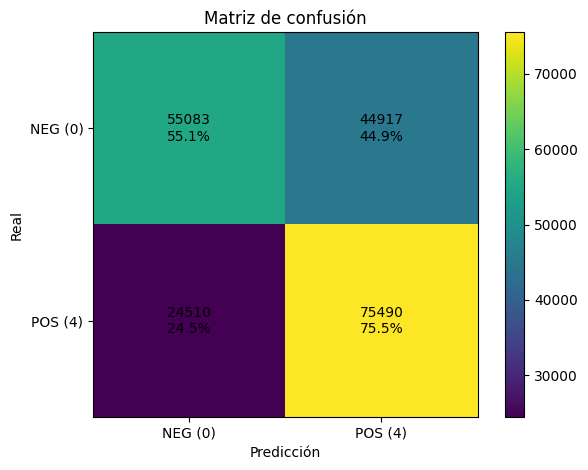

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if not ('tiene_target' in globals() and bool(tiene_target)):
    print("⚠ No hay columna 'target'. Ejecuta esta celda sólo si existe `target` con valores {0,4}.")
else:
    # Filtrar a clases 0/4 por seguridad
    mask = df["target"].isin([0,4]) & df["sentiment_pred"].isin([0,4])
    y_true = (df.loc[mask, "target"] == 4).astype(int).values  # 0->neg, 1->pos
    y_pred = (df.loc[mask, "sentiment_pred"] == 4).astype(int).values

    # CM: [[TN, FP], [FN, TP]]
    TN = int(((y_true==0) & (y_pred==0)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())
    TP = int(((y_true==1) & (y_pred==1)).sum())
    cm = np.array([[TN, FP],[FN, TP]], dtype=int)

    # Tablas legibles (conteos y porcentajes)
    df_counts = pd.DataFrame(
        cm,
        index=["Real NEG (0)","Real POS (4)"],
        columns=["Pred NEG (0)","Pred POS (4)"]
    )
    row_sums = df_counts.sum(axis=1).replace(0, np.nan)
    col_sums = df_counts.sum(axis=0).replace(0, np.nan)
    total = df_counts.values.sum()

    df_row_pct = (df_counts.div(row_sums, axis=0) * 100).round(2)
    df_col_pct = (df_counts.div(col_sums, axis=1) * 100).round(2)
    df_all_pct = (df_counts / total * 100).round(2) if total>0 else df_counts.astype(float)

    print("Conteos (absolutos):")
    display(df_counts)
    print("\nPorcentajes por FILA (≈ recall por clase):")
    display(df_row_pct)
    print("\nPorcentajes por COLUMNA (≈ precision por clase):")
    display(df_col_pct)
    print("\nPorcentajes sobre el TOTAL:")
    display(df_all_pct)

    # Gráfico de la matriz (1 figura, sin estilos/colores explícitos)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')  # sin cmap explícito
    plt.title("Matriz de confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.xticks([0,1], ["NEG (0)","POS (4)"])
    plt.yticks([0,1], ["NEG (0)","POS (4)"])

    # Anotar cada celda con conteo y % por fila
    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            fila = cm[i, :].sum()
            pct_row = (val / fila * 100) if fila > 0 else 0.0
            plt.text(j, i, f"{val}\n{pct_row:.1f}%", ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()


## 14. Gráficos rápidos (distribución de scores)

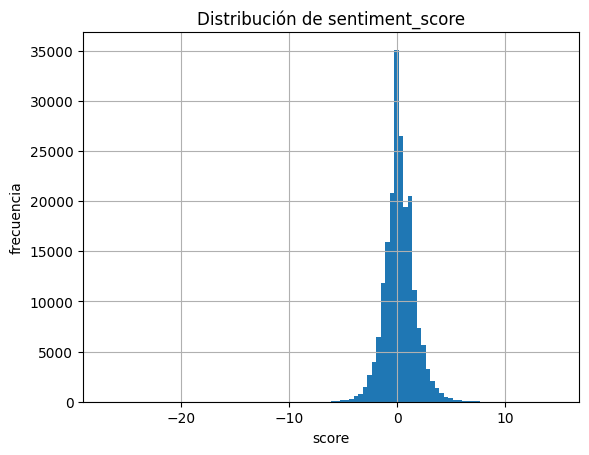

In [14]:
import matplotlib.pyplot as plt

plt.figure()
df["sentiment_score"].hist(bins=100)
plt.title("Distribución de sentiment_score")
plt.xlabel("score")
plt.ylabel("frecuencia")
plt.show()

## 15. Ejemplos cualitativos

In [19]:
import numpy as np
import pandas as pd
from IPython.display import display

if not ('tiene_target' in globals() and bool(tiene_target)):
    print("No hay columna 'target'. Ejecuta esta celda sólo si existe `target` con valores {0,4}.")
elif 'sentiment_pred' not in df.columns or 'sentiment_score' not in df.columns:
    print("Faltan columnas 'sentiment_pred' o 'sentiment_score'. Ejecuta las celdas de scoring/predicción antes.")
else:
    # Máscaras de error
    mask_fp = (df['target'] == 0) & (df['sentiment_pred'] == 4)  # Falsos Positivos
    mask_fn = (df['target'] == 4) & (df['sentiment_pred'] == 0)  # Falsos Negativos

    # Subconjuntos con columnas relevantes
    cols = [text_col, 'sentiment_score', 'target', 'sentiment_pred']
    ejemplos_fp = df.loc[mask_fp, cols].copy()
    ejemplos_fn = df.loc[mask_fn, cols].copy()

    # Distancia al umbral (si existe), para priorizar errores más "claros"
    umbral = float(mejor_umbral) if 'mejor_umbral' in globals() else 0.0
    ejemplos_fp['dist_umbral'] = (ejemplos_fp['sentiment_score'] - umbral).abs()
    ejemplos_fn['dist_umbral'] = (ejemplos_fn['sentiment_score'] - umbral).abs()

    # Selección de 5 casos (los de mayor distancia al umbral)
    top_fp = ejemplos_fp.sort_values('dist_umbral', ascending=False).head(5)
    top_fn = ejemplos_fn.sort_values('dist_umbral', ascending=False).head(5)

    # --- SALIDA LEGIBLE (texto) ---
    print("──────────── FALSOS POSITIVOS (Real NEG=0, Pred POS=4) ────────────")
    for _, row in top_fp.iterrows():
        txt = str(row[text_col]).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | Real: NEG | Pred: POS ✗\n")

    print("──────────── FALSOS NEGATIVOS (Real POS=4, Pred NEG=0) ────────────")
    for _, row in top_fn.iterrows():
        txt = str(row[text_col]).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | Real: POS | Pred: NEG ✗\n")

    # --- TABLAS (útiles para exportar/copiar) ---
    print("Tabla — 5 FALSOS POSITIVOS")
    display(top_fp.drop(columns=['dist_umbral']).reset_index(drop=True))

    print("Tabla — 5 FALSOS NEGATIVOS")
    display(top_fn.drop(columns=['dist_umbral']).reset_index(drop=True))


──────────── FALSOS POSITIVOS (Real NEG=0, Pred POS=4) ────────────
Texto: Watching the parade from home  But Loving all the highlights from the season! I LOVE THE LAKERS!!!!!!!!!!!!!!!!!!!!!!!xoxoxoxoxoxoxoxoxoxo...
Score: 14.450 | Real: NEG | Pred: POS ✗

Texto: I scraped my hand  but @toyayu tended to my wound, I feel like I'm five again! She's soooo sweet! I love my mommy!!...
Score: 9.240 | Real: NEG | Pred: POS ✗

Texto: I scraped my hand  but @toyayu tended my wound, I feel like I'm five again! She's soooo sweet! I love my mommy!!...
Score: 9.240 | Real: NEG | Pred: POS ✗

Texto: @selenagomez Selly i`m begging you. please replay to me. you`ll make my day. please please  i love you sooooooo much!!!!!!!!!!!!!!!!!!!...
Score: 9.171 | Real: NEG | Pred: POS ✗

Texto: @selenagomez Selly i`m begging you. please replay to me. you`ll make my day. please please  i love you sooooooo much!!!!!!!!!!!!!!!!!!!...
Score: 9.171 | Real: NEG | Pred: POS ✗

──────────── FALSOS NEGATIVOS (Real POS=4

,text,sentiment_score,target,sentiment_pred
0,Watching the parade from home But Loving all ...,14.45000,0,4
1,I scraped my hand but @toyayu tended to my wo...,9.24000,0,4
2,I scraped my hand but @toyayu tended my wound...,9.24000,0,4
3,@selenagomez Selly i`m begging you. please rep...,9.17125,0,4
4,@selenagomez Selly i`m begging you. please rep...,9.17125,0,4


Tabla — 5 FALSOS NEGATIVOS


,text,sentiment_score,target,sentiment_pred
0,@ajayrochester DO IT DO IT DO IT DO IT DO IT D...,-10.00000,4,0
1,i keep having to sneeze...but don't. popcorn's...,-7.06250,4,0
2,'little exam from English' tomorrow Little ?!...,-6.63000,4,0
3,"damn.,,,i still dont know wat the poient of th...",-6.48125,4,0
4,Argh! Stupid ppl in stupid loud cars wake me u...,-6.33750,4,0


## 16. Exportación a CSV

In [20]:
cols = [text_col, "sentiment_score", "sentiment_pred"]
if "target" in df.columns:
    cols += ["target"]
    if "correcto" in df.columns:
        cols += ["correcto"]

out_path = "resultados_sentimientos_v2.csv"
df[cols].to_csv(out_path, index=False)
print(f"✓ Resultados exportados a: {out_path} (total={len(df):,})")

✓ Resultados exportados a: resultados_sentimientos_v2.csv (total=200,000)
